**Download the sample provided data with image and ground truth into the working directory**

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/13qJbwvLihbUjILvBHpve36tu_Rum1BPi/view?usp=sharing -O data.zip
!unzip -o data.zip -d Image/
!rm data.zip

Downloading...
From: https://drive.google.com/uc?id=13qJbwvLihbUjILvBHpve36tu_Rum1BPi
To: /content/data.zip
100% 4.02M/4.02M [00:00<00:00, 48.0MB/s]
Archive:  data.zip
  inflating: Image/GT.gpkg           
  inflating: Image/__MACOSX/._GT.gpkg  
  inflating: Image/Image.tif         
  inflating: Image/__MACOSX/._Image.tif  


**Install Libraries that are not present in colab**

In [ ]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 43.9 MB/s eta 0:00:00


**Import Required Libraries**

In [ ]:
import tensorflow as tf
import numpy as np
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from skimage import exposure
import geopandas as gpd
from rasterio import features
from sklearn.model_selection import train_test_split

**Load the satellite image from downloaded directory and check it for its properties as well as quality**

In [ ]:
src = rasterio.open("Image/Image.tif")
img = src.read()

In [ ]:
img.shape

(5, 472, 807)

It shows that there are five bands which is B02, B03, B04, B08 and B012. This is used in the training but for visualization we only need bands 2,3,4 in 4,3,2 sequence. Now lets make that change

In [ ]:
img_vis = img[[4,3,2],:,:]

Let's plot the image to see how does it look

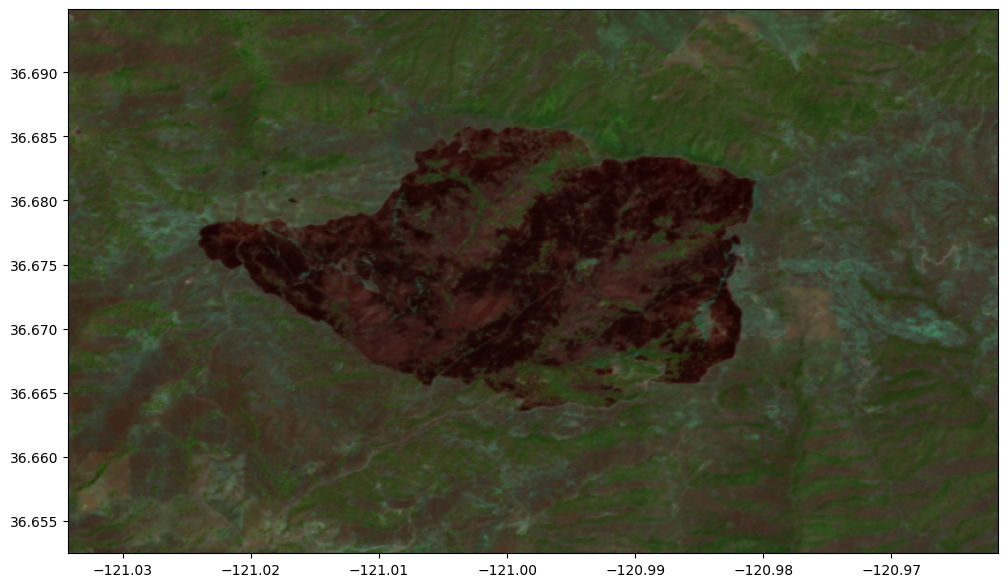

In [ ]:
fig, ax = plt.subplots(1, figsize=(12, 12))
show(img_vis,transform=src.transform, ax = ax)
ax.ticklabel_format(useOffset=False, style='plain')

The image looks too dark, so let's enhance it a bit

In [ ]:
def normalize(arr):
    for i in range(arr.shape[0]):
        p5, p95 = np.percentile(arr[i, :, :], (5, 95))
        arr[i, :, :] = exposure.rescale_intensity(arr[i, :, :],
                                                      in_range=(arr.min(), arr.max()))
    return arr

img_vis_norm = normalize(img_vis)

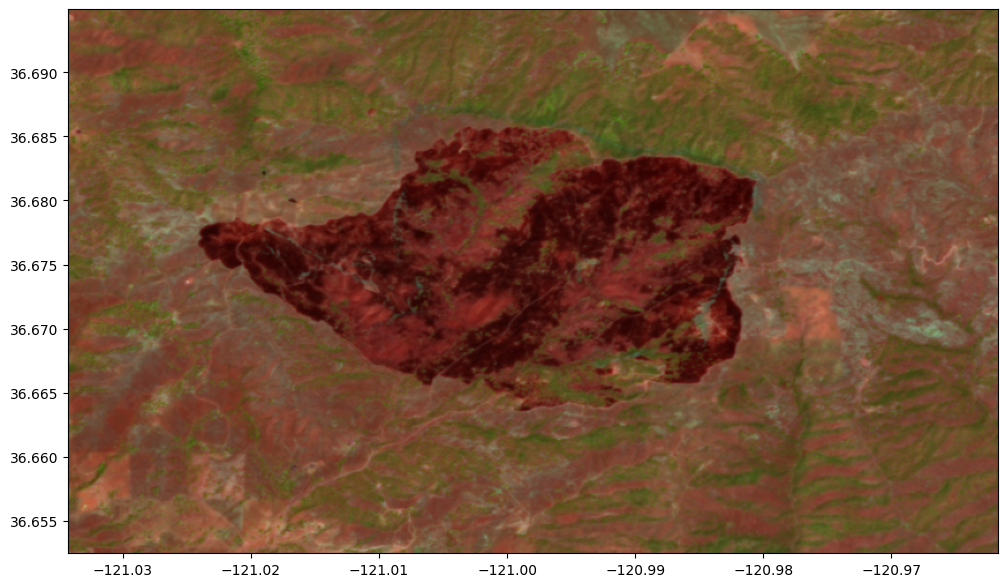

In [ ]:
fig, ax = plt.subplots(1, figsize=(12, 12))
show(img_vis_norm,transform=src.transform, ax = ax)
ax.ticklabel_format(useOffset=False, style='plain')

This shows much more clearly the burnt area compared to non-burnt area. Now, lets load the ground truth data that we have.

In [ ]:
GroundTruth = gpd.read_file("Image/GT.gpkg").to_crs(epsg=4326)

Lets visualize it on top of the satellite image

<Axes: >

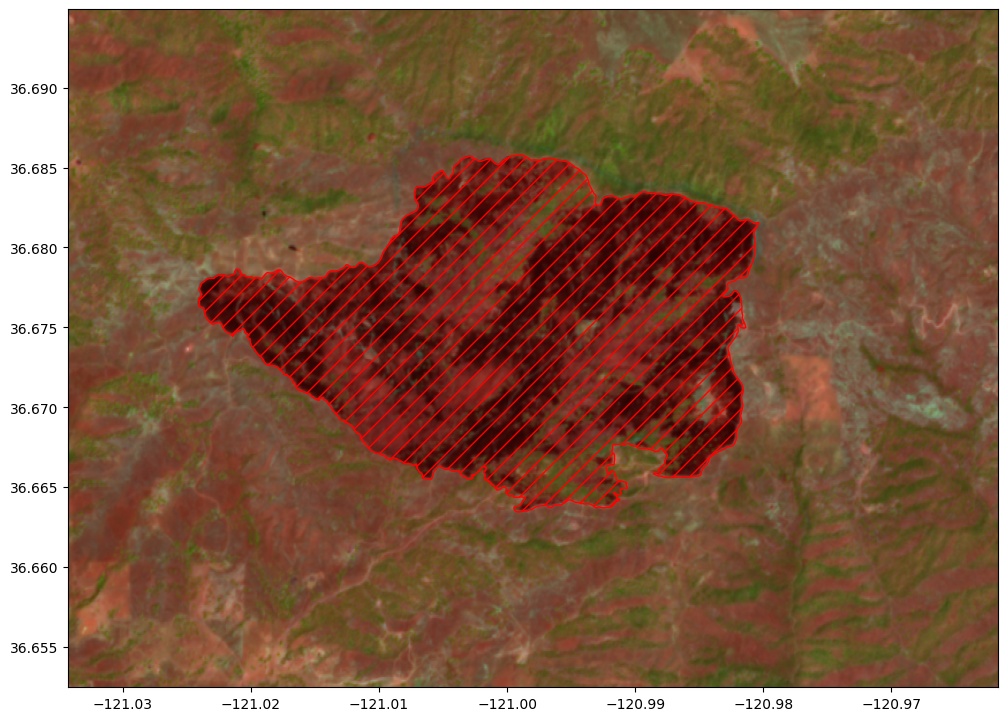

In [ ]:
fig, ax = plt.subplots(1, figsize=(12, 12))
show(img_vis_norm,transform=src.transform, ax = ax)
ax.ticklabel_format(useOffset=False, style='plain')
GroundTruth.plot(ax=ax,
        color= "none",
        edgecolor= "red",
        hatch= "//")

This shows that our image and training dataset match quite well. Now, lets convert the ground truth into an image such that we can use it to train the model.

In [ ]:
shapes = ((geom,1) for geom in GroundTruth.geometry)
raster_GT = features.rasterize(shapes=shapes, fill=0,out_shape = img_vis_norm[0].shape,  transform=src.transform)

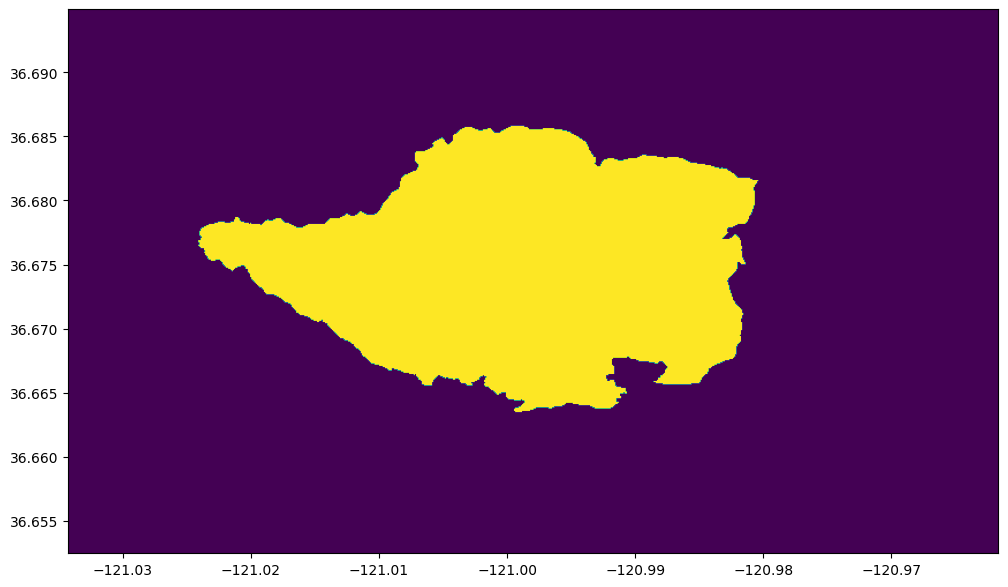

In [ ]:
fig, ax = plt.subplots(1, figsize=(12, 12))
show(raster_GT,transform=src.transform, ax = ax)
ax.ticklabel_format(useOffset=False, style='plain')

Now the satellite image will serve us as the training data while the raster we just created will serve us as the ground truth. Most of the neural network models take the band as the last axis of the image instead of first, therefore let us change our image to band last format.

In [ ]:
XData = img.transpose((1, 2, 0))
YData = np.expand_dims(raster_GT,-1)

Now, the neural network models often take the images as small patches. The following steps will make those patches from this image.

In [ ]:
PATCHSIZE = 32
NBANDS = XData.shape[-1]

def gridwise_sample(imgarray, patchsize):
    """Extract sample patches of size patchsize x patchsize from an image (imgarray) in a gridwise manner.
    """
    nrows, ncols, nbands = imgarray.shape
    patchsamples = np.zeros(shape=(0, patchsize, patchsize, nbands),
                            dtype=imgarray.dtype)
    for i in range(int(nrows/patchsize)):
        for j in range(int(ncols/patchsize)):
            tocat = imgarray[i*patchsize:(i+1)*patchsize,
                             j*patchsize:(j+1)*patchsize, :]
            tocat = np.expand_dims(tocat, axis=0)
            patchsamples = np.concatenate((patchsamples, tocat),
                                          axis=0)
    return patchsamples

XPatches = gridwise_sample(XData, PATCHSIZE)
YPatches = gridwise_sample(YData, PATCHSIZE)

print("There are %i number of training patches" % (XPatches.shape[0]))

There are 350 number of training patches


We have now made 350 training samples from which our model can learn. Now lets check if it is okay or not.

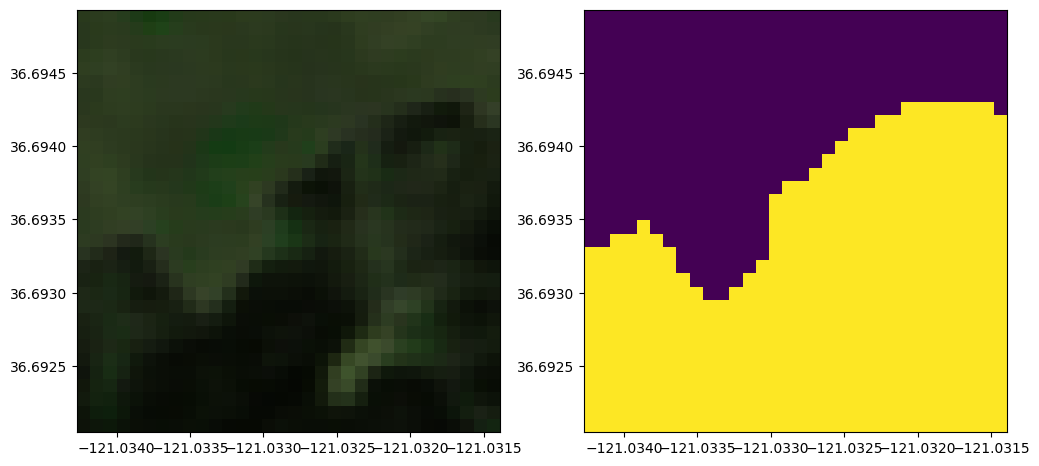

In [ ]:
n = 85 #sample number
fig, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].imshow(XPatches[n,:,:,[2,3,1]].transpose((0, 1, 2)))
ax[1].imshow(YPatches[n,:,:,0])

ax[0].ticklabel_format(useOffset=False, style='plain')
ax[1].ticklabel_format(useOffset=False, style='plain')

**Now, Lets divide this data into training and test sets randomly**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    XPatches, YPatches, test_size=0.2, random_state=42)

In [ ]:
print(f"Training Set has {X_train.shape[0]} Number of samples")
print(f"Test Set has {X_test.shape[0]} Number of samples")

Training Set has 280 Number of samples
Test Set has 70 Number of samples


Now you can save this into a numpy array so that while training you can only load the array and not whole dataset

In [ ]:
np.save("Image/X_train.npy",X_train)
np.save("Image/X_test.npy",X_test)
np.save("Image/y_train.npy",y_train)
np.save("Image/y_test.npy",y_test)

This completes the tutorial on data preparation as it provides all details on how images can be loaded and converted into the desired format.